<a href="https://colab.research.google.com/github/ZeXuan0512/Weather-Advisor/blob/main/Weather_Advisor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Configuration

In [ ]:
!pip install python-dotenv

In [ ]:
import os
from dotenv import load_dotenv
import requests
import pandas as pd
import logging
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import matplotlib.cm as cm
import spacy
import re
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

In [ ]:
# --- Upload env to colab ---
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    uploaded = files.upload()  # This opens the file picker in Colab
else:
    print(".env file must be placed in the same directory when running locally.")

Saving .env to .env


In [ ]:
load_dotenv(".env")

# Load NLP model once
nlp = spacy.load("en_core_web_sm")

# Weather Data Functions

In [ ]:
cache = {}

def get_weather_data(location, forecast_days=5):
    current_time = time.time()
    cache_key = f"{location}-{forecast_days}"

    # Check if data is cached and not expired (valid for 10 minutes)
    if cache_key in cache and current_time - cache[cache_key]['timestamp'] < 600:
        return cache[cache_key]['data']

    # Initialize the output data structure
    parsed_data = {
        "current": [],
        "forecast": []
    }

    try:
        # --- API Call Setup ---
        url = "http://api.weatherapi.com/v1/forecast.json"
        api_key = os.getenv("WEATHER_API_KEY")
        params = {
            "q": location,
            "key": api_key,
            "days": forecast_days
        }
        resp = requests.get(url, params=params)

        # --- Check API response ---
        if resp.status_code == 200:
            try:
                # Parse the response only once
                response_data = resp.json()

                # Process current weather data
                current_data = response_data.get("current", {})
                if current_data:
                    parsed_data["current"].append({
                        "datetime": current_data.get("last_updated", "N/A"),
                        "weather condition": current_data.get("condition", {}).get("text", "N/A"),
                        "temperature": current_data.get("temp_c", "N/A"),
                        "wind speed": current_data.get("wind_kph", "N/A"),
                        "humidity": current_data.get("humidity", "N/A"),
                        "feelslike_c": current_data.get("feelslike_c", "N/A"),
                        "precipitation": current_data.get("precip_mm", "N/A"),
                    })

                # Process forecast data
                forecast_data = response_data.get("forecast", {}).get("forecastday", [])
                for item in forecast_data:
                    parsed_data["forecast"].append({
                        "datetime": item.get("date", "N/A"),
                        "weather condition": item.get("day", {}).get("condition", {}).get("text", "N/A"),
                        "temperature": item.get("day", {}).get("avgtemp_c", "N/A"),
                        "wind speed": item.get("day", {}).get("maxwind_kph", "N/A"),
                        "humidity": item.get("day", {}).get("avghumidity", "N/A"),
                        "rain percentage": item.get("day", {}).get("daily_chance_of_rain", "N/A"),
                        "precipitation": item.get("day", {}).get('totalprecip_mm', "N/A")
                    })

                # Save to cache only after successful processing
                cache[cache_key] = {
                    'data': parsed_data,
                    'timestamp': current_time
                }
                return parsed_data

            except (KeyError, TypeError) as e:
                error_message = f"Data parsing error: {str(e)}"
                logging.error(error_message)
                return {"error": error_message}

        else:
            # Log the error response
            error_msg = resp.json().get("message", "No message provided")
            logging.error(f"Error {resp.status_code}: {error_msg}")
            return {"error": f"API Error {resp.status_code}: {error_msg}"}

    except requests.RequestException as e:
        logging.error(f"Network error: {str(e)}")
        return {"error": f"Network error: {str(e)}"}

# Visualisation Functions


In [ ]:
def create_temperature_visualisation(weather_data, output_type='display'):
    # Step 1: Extract forecast dates and temperatures efficiently
    try:
        dates = [datetime.strptime(item['datetime'], "%Y-%m-%d") for item in weather_data["forecast"]]
        temperatures = [item['temperature'] for item in weather_data["forecast"]]

        # Step 2: Create the line graph
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.plot(dates, temperatures, marker='o', linestyle='-', color='blue', label='Forecast Temperature (°C)')

        # Format date on x-axis
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator())
        plt.xticks(rotation=45)

        # Step 3: Set graph title and labels
        ax.set_title("Daily Temperature")
        ax.set_xlabel("Date")
        ax.set_ylabel("Temperature (°C)")
        ax.legend()
        ax.grid(True)

        # Step 4: Rotate x-ticks for better readability
        plt.xticks(rotation=45)

        # Step 5: Output the visualisation
        if output_type == 'figure':
            plt.close(fig)
            return fig
        else:
            plt.show()
            plt.close(fig)

    except KeyError as e:
        print(f"Missing key in weather data: {e}")
    except Exception as e:
        print(f"Error while generating the graph: {e}")

In [ ]:
def create_precipitation_visualisation(weather_data, output_type='display'):
    try:
        # Step 1: Extract forecast dates and precipitation amounts
        dates = [datetime.strptime(item['datetime'], "%Y-%m-%d") for item in weather_data["forecast"]]
        precipitation = [item['precipitation'] for item in weather_data["forecast"]]

        # Step 2: Normalize precipitation values for color mapping
        norm = plt.Normalize(min(precipitation), max(precipitation))
        colors = cm.Blues(norm(precipitation))  # Use 'Blues' colormap for a gradient effect

        # Step 3: Create the bar graph with a gradient color scheme
        fig, ax = plt.subplots(figsize=(8, 5))
        bars = ax.bar(dates, precipitation, color=colors, label='Precipitation (mm)')

        # Step 4: Set graph title and labels
        ax.set_title("Forecast Precipitation Trend")
        ax.set_xlabel("Date")
        ax.set_ylabel("Precipitation (mm)")
        ax.legend()
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

        # Step 5: Format x-axis to display dates only (one per day)
        ax.xaxis.set_major_locator(mdates.DayLocator())  # One tick per day
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as YYYY-MM-DD
        plt.xticks(rotation=45)  # Rotate for better readability

        # Step 6: Add colorbar to indicate precipitation intensity
        sm = cm.ScalarMappable(cmap='Blues', norm=norm)
        sm.set_array([])  # Empty array for colorbar
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label("Precipitation Intensity (mm)")

        # Step 7: Output the visualisation
        if output_type == 'figure':
            plt.close(fig)
            return fig
        else:
            plt.show()
            plt.close(fig)

    except KeyError as e:
        print(f"Missing key in weather data: {e}")
    except Exception as e:
        print(f"Error while generating the graph: {e}")


# Natural Language Processing

In [ ]:
def parse_weather_question(question):
    # Step 1: Initialize default values
    location = None
    days = None
    attribute = None

    # Step 2: Define synonyms for weather attributes
    attribute_keywords = {
        "temperature": ["temperature", "hot", "cold", "warm"],
        "humidity": ["humidity", "humid"],
        "wind speed": ["wind", "windy"],
        "chance of rain": ["rain", "raining", "rainy"],
        "sunny": ["sunny", "not raining", "not rainy"],
        "weather condition": ["weather", "forecast", "weather condition"],
        "precipitation": ["precipitation", "rainfall", "rain in mm"]
    }

    # Step 3: Process the question with the NLP model
    doc = nlp(question)

    # Step 4: Extract location using Named Entity Recognition (NER)
    for ent in doc.ents:
        if ent.label_ == "GPE":
            location = ent.text
            break

    # Fallback: Check noun chunks for proper nouns (if no GPE found)
    if not location:
        for chunk in doc.noun_chunks:
            if chunk.root.pos_ == 'PROPN':
                location = chunk.text
                break

    # Step 5: Extract weather attribute using keyword matching
    for token in doc:
        for attr, keywords in attribute_keywords.items():
            if token.lemma_ in keywords:
                attribute = attr
                break
        if attribute:
            break

    # Step 6: Extract days from the question (based on common phrases)
    q_lower = question.lower()
    if "now" in q_lower:
        days = -1
    elif "today" in q_lower or "later" in q_lower:
        days = 0
    elif "tomorrow" in q_lower or "next day" in q_lower:
        days = 1
    elif match := re.search(r"(?:next|in) (\d+) days?", q_lower):
        days = int(match.group(1))


    # Step 7: Return the structured result
    return {
        "location": location,
        "days": days,
        "attribute": attribute
    }


In [ ]:
def format_day_label(item_date):
    today = datetime.today().date()
    tomorrow = today + timedelta(days=1)

    if item_date == today:
        return "today"
    elif item_date == tomorrow:
        return "tomorrow"
    return f"on {item_date}"

In [ ]:
def weather_attributes_response(response, attribute, item, days=0):
    # Mapping of attributes to response formats
    attribute_map = {
        "temperature": f"is around {item['temperature']}°C <br>",
        "humidity": f"is {item['humidity']}% <br>",
        "wind speed": f"is {item['wind speed']} km/h <br>",
        "weather condition": f"is {item['weather condition']} <br>",
        "precipitation": f"is {item['precipitation']}mm <br>"
    }

    # Check for standard attributes
    if attribute in attribute_map:
        response += attribute_map[attribute]
        return response

    # Special handling for "chance of rain"
    if attribute == "chance of rain" and days != -1:
        item_date = datetime.strptime(item['datetime'], "%Y-%m-%d").date()
        day_label = format_day_label(item_date)
        chance = item['rain percentage']
        rain_status = "high" if chance > 50 else "low"
        response += f"There is a {rain_status} chance of rain {day_label} — {chance}%.<br>"
        return response

    # Special handling for "sunny"
    if attribute == "sunny" and days != -1:
        is_sunny = item['rain percentage'] <= 50
        response += "is a sunny day." if is_sunny else "is a rainy day.<br>"
        return response

    # Fallback for unsupported attributes
    return f"Please restructure your sentence."

In [ ]:
def generate_weather_response(parsed_question, weather_data):
    location = parsed_question.get("location", "the location")
    days = parsed_question.get("days", 1)
    attribute = parsed_question.get("attribute", "weather condition")
    response = ""

    # Mapping for day descriptions
    day_map = {-1: "current", 0: "today", 1: "tomorrow"}
    day_desc = day_map.get(days, f"in {days} days")

    # Choose current data or forecast
    if days == -1:
        data = weather_data.get("current", [])
        if not data:
            return f"Sorry, I couldn't retrieve current weather data for {location}."
        data = data[0]  # Extract the single current weather entry
    else:
        data = weather_data.get("forecast", [])
        if not data:
            return f"Sorry, I couldn't retrieve forecast data for {location}."

    # Formulate the response
    if days <= 1:
        response = f"The {attribute} {day_desc} in {location} "
        response = weather_attributes_response(response, attribute, data[0], days)
    else:
        response = f"The {attribute} in {location}: <br>"
        for item in data:
            response += f"on {item['datetime']} "
            response = weather_attributes_response(response, attribute, item, days)

    return response


# User Interface

In [ ]:
# --- Widgets ---
time_dropdown = widgets.Dropdown(
    options=['1', '2', '3', '4', '5'],
    value='1',
    description='Days:',
)

weather_dropdown = widgets.Dropdown(
    options=['all', 'temperature', 'humidity', 'precipitation', 'wind speed', 'weather condition'],
    value='all',
    description='Weather attributes:',
)

city_input = widgets.Text(
    placeholder='Enter city name...',
    description='City:',
)

submit_button = widgets.Button(
    description='Submit',
    button_style='success',
)

return_button = widgets.Button(
    description='Return',
    button_style='success',
)

dashboard_output = widgets.Output()

chat_output = widgets.Output()

chat_input = widgets.Text(placeholder="Ask about the weather...")

In [ ]:
# --- Dashboard Tab ---
def on_submit_clicked(b):
    with dashboard_output:
        clear_output()
        selected_days = int(time_dropdown.value)
        selected_city = city_input.value.strip()
        selected_attributes = str(weather_dropdown.value)
        if not selected_city:
            print("Please enter a valid city name.")
            with dashboard_output:
               display(widgets.VBox([time_dropdown, weather_dropdown, city_input, submit_button]))
            return

        dashboard_city = widgets.Label(f"Selected city: {selected_city}")
        dashboard_days = widgets.Label(f"Forecast days: {selected_days}")

        # Display city info
        display(widgets.VBox([dashboard_city, dashboard_days]))

        # Get weather data
        data = get_weather_data(selected_city, selected_days + 1)
        df = pd.DataFrame(data["forecast"])
        if selected_attributes != "all":
            df = df[["datetime", selected_attributes]]

        prec_fig = create_precipitation_visualisation(data, output_type='figure')
        temp_fig = create_temperature_visualisation(data, output_type='figure')
        display(df)

        # --- Display the graph ---
        if selected_attributes == "all":
            display(temp_fig)
            display(prec_fig)

        if selected_attributes == "precipitation":
            plt.close(prec_fig)

        if selected_attributes == "temperature":
            display(temp_fig)

        # Show continue buttons
        buttons_box = widgets.HBox([return_button])
        display(buttons_box)

# Dashboard return handler
def on_return_clicked(b):
    with dashboard_output:
        clear_output()
        # Reset to input form
        display(widgets.VBox([time_dropdown, weather_dropdown, city_input, submit_button]))

In [ ]:
# --- Chat Tab ---
def handle_chat_input(sender):
    with chat_output:
        display(HTML(f"""
            <b>User:</b> {chat_input.value}<br>
        """))

        missing_info = False
        parsed_question = parse_weather_question(chat_input.value)

        if parsed_question["location"] is None:
            display(HTML(f"""
                <b>Dr. Forecast:</b> Please provide the location name.<br>
            """))
            missing_info = True

        if parsed_question["days"] is None:
            display(HTML(f"""
                <b>Dr. Forecast:</b> Please provide a time reference, such as 'today', 'tomorrow', or 'next 3 days'.<br>
            """))
            missing_info = True

        if parsed_question["attribute"] is None:
            display(HTML(f"""
                <b>Dr. Forecast:</b> Please specify which weather details you'd like to know more about.<br>
            """))
            missing_info = True

        if not missing_info:
            data = get_weather_data(parsed_question["location"], parsed_question["days"] + 1)
            display(HTML(f"""
                <b>Dr. Forecast:</b> {generate_weather_response(parsed_question, data)}<br>
            """))
        chat_input.value = ""

# Main Application Logic

In [ ]:
# Initial display
with dashboard_output:
    clear_output()
    display(widgets.VBox([time_dropdown, weather_dropdown, city_input, submit_button]))
with chat_output:
    clear_output()
    display(HTML("""
        <b>Dr. Forecast:</b> Hi! I'm Dr. Forecast — your personal weather assistant.<br>
        <b>Dr. Forecast:</b> Here are a few tips to get the best results:<br>
        <ul>
          <li>Please provide the full name of the location you'd like the weather forecast for.</li>
          <li>Let me know how many days you want the weather forecast for <br> (today/tomorrow/next 2 days).</li>
        </ul>
    """))

# Attach events
submit_button.on_click(on_submit_clicked)
return_button.on_click(on_return_clicked)
chat_input.on_submit(handle_chat_input)
chat_box = widgets.VBox([chat_output, chat_input])

# --- Tabs ---
dashboard_box = widgets.VBox([dashboard_output])  # Now includes dynamic content
tab = widgets.Tab(children=[dashboard_box, chat_box])
tab.set_title(0, "Dashboard")
tab.set_title(1, "Chat")

# Custom label (Menu) beside the tabs
menu_label = widgets.HTML("<b>Menu:</b>")
header = widgets.HBox([menu_label, tab])

display(header)

# Testing and Examples

In [ ]:
test_data = get_weather_data("Penang", forecast_days=5)
current_df = pd.DataFrame(test_data["current"])
forecast_df = pd.DataFrame(test_data["forecast"])

In [ ]:
current_df

,datetime,weather condition,temperature,wind speed,humidity,feelslike_c,precipitation
0,2025-05-08 03:45,Light rain,28.2,5.8,84,33.3,0.75


In [ ]:
forecast_df

,datetime,weather condition,temperature,wind speed,humidity,rain percentage,precipitation
0,2025-05-08,Moderate rain,28.0,15.8,78,88,5.45
1,2025-05-09,Moderate rain,28.1,13.3,79,88,7.00
2,2025-05-10,Moderate rain,27.8,16.9,80,86,16.21
3,2025-05-11,Moderate rain,27.8,15.5,79,89,7.98
4,2025-05-12,Moderate rain,27.4,16.9,81,89,8.42


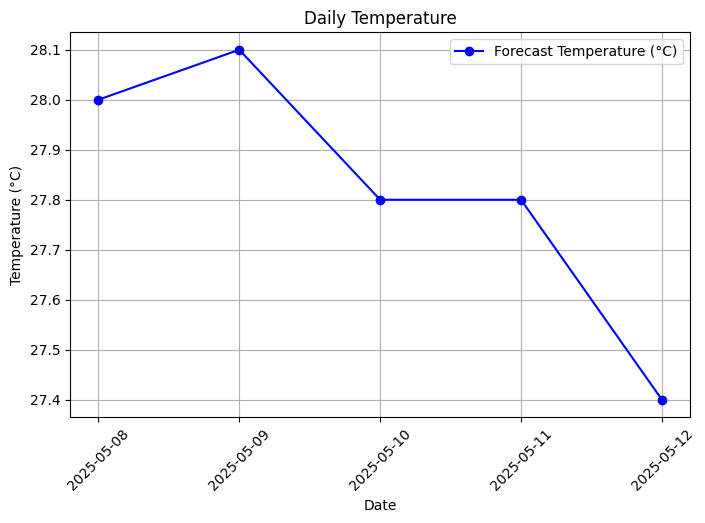

In [ ]:
create_temperature_visualisation(test_data, output_type='display')

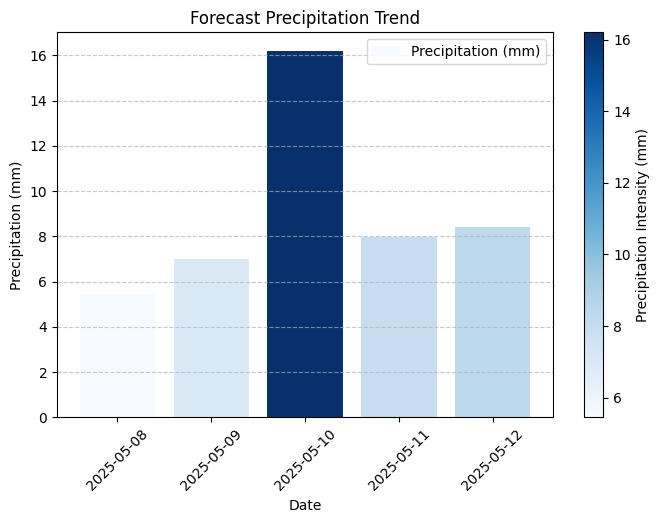

In [ ]:
create_precipitation_visualisation(test_data, output_type='display')

In [ ]:
test_parsed_questions = parse_weather_question("What is Kuala Lumpur temperature in next 4 days")
print(test_parsed_questions)

{'location': 'Kuala Lumpur', 'days': 4, 'attribute': 'temperature'}


In [ ]:
test_response = generate_weather_response(test_parsed_questions, test_data)
print(test_response)

The temperature in Kuala Lumpur: <br>on 2025-05-08 is around 28.0°C <br>on 2025-05-09 is around 28.1°C <br>on 2025-05-10 is around 27.8°C <br>on 2025-05-11 is around 27.8°C <br>on 2025-05-12 is around 27.4°C <br>
